## 公寓房价预测  
数据集取自import.io，公寓房价信息属于纽约地区。




In [193]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

### 1.加载数据集，并进行粗略查看

In [194]:
data=pd.read_csv('./Apartment.csv')

In [195]:
data.columns

Index(['routablemask_link', 'routablemask_link/_text',
       'routablemask_link/_title', 'routablemask_link_numbers',
       'routablemask_content', 'imagebadge_value', 'imagebadge_value_numbers',
       'routable_link', 'routable_link/_text', 'routable_link/_title',
       'routable_link_numbers', 'listingtype_value', 'pricelarge_value',
       'pricelarge_value_prices', 'propertyinfo_value',
       'propertyinfo_value_numbers', 'fineprint_value',
       'fineprint_value_numbers', 'tozcount_number', 'tozfresh_value',
       'tablegrouped_values', 'tablegrouped_values_prices', '_PAGE_NUMBER'],
      dtype='object')

In [196]:
data.head(5).T

,0,1,2,3,4
routablemask_link,http://www.zillow.com/b/2-Ellwood-St-New-York-...,http://www.zillow.com/b/603-W-140th-St-New-Yor...,http://www.zillow.com/homedetails/9-E-129th-St...,http://www.zillow.com/homedetails/710-Riversid...,http://www.zillow.com/homedetails/413-E-84th-S...
routablemask_link/_text,5 photos,10 photos,NaN,9 photos,5 photos
routablemask_link/_title,NaN,NaN,NaN,NaN,NaN
routablemask_link_numbers,5,10,NaN,9,5
routablemask_content,NaN,NaN,NaN,NaN,NaN
imagebadge_value,5 photos,10 photos,NaN,9 photos,5 photos
imagebadge_value_numbers,5,10,NaN,9,5
routable_link,http://www.zillow.com/b/2-Ellwood-St-New-York-...,http://www.zillow.com/b/603-W-140th-St-New-Yor...,http://www.zillow.com/homedetails/9-E-129th-St...,http://www.zillow.com/homedetails/710-Riversid...,http://www.zillow.com/homedetails/413-E-84th-S...
routable_link/_text,2 Ellwood St,603 W 140th St,"9 E 129th St # 1, New York, NY10035","710 Riverside Dr APT 2C, New York, NY10031","413 E 84th St APT 8, New York, NY10028"
routable_link/_title,"2 Ellwood St APT 5H, New York, NY Real Estate","603 W 140th St APT 44, New York, NY Real Estate","9 E 129th St # 1, New York, NY Real Estate","710 Riverside Dr APT 2C, New York, NY Real Estate","413 E 84th St APT 8, New York, NY Real Estate"


观察上表，可以发现许多信息是无用冗杂的，仅保留'listingtype_value'、'pricelarge_value_prices'、
'routable_link/_text'、'propertyinfo_value'。

In [197]:
data=data[['listingtype_value','routable_link/_text','propertyinfo_value','pricelarge_value_prices']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
listingtype_value          500 non-null object
routable_link/_text        500 non-null object
propertyinfo_value         500 non-null object
pricelarge_value_prices    339 non-null float64
dtypes: float64(1), object(3)
memory usage: 15.7+ KB


### 2.数据处理，特征工程

根据'listingtype_value'特征拆分数据为单个单元与多个单元，单个单元样本有价格，此处研究该类样本。

In [198]:
single_data=data[data['listingtype_value'].str.contains('Apartment For')]

# 处理完毕后删除该特征即可
single_data.drop(['listingtype_value'],axis=1,inplace=True)
single_data.reset_index(drop=True,inplace=True)
len(single_data) # 样本数目

339

In [199]:
single_data.head(5).T

,0,1,2,3,4
routable_link/_text,"9 E 129th St # 1, New York, NY10035","710 Riverside Dr APT 2C, New York, NY10031","413 E 84th St APT 8, New York, NY10028","324 Pleasant Ave APT 6E, New York, NY10035","217 Thompson St APT 6, New York, NY10012"
propertyinfo_value,1 bd • 1 ba,"2 bds • 2 ba • 1,016 sqft",Studio • 1 ba,2 bds • 1 ba,2 bds • 1 ba
pricelarge_value_prices,1750,3000,2300,2500,2800


缺失值查看

In [200]:
single_data.isnull().sum()

routable_link/_text        0
propertyinfo_value         0
pricelarge_value_prices    0
dtype: int64

没有缺失值，尤其是保证了房价pricelarge_value_prices特征列无缺失值。

在特征propertyinfo_value属性信息中提取经常出现的 卧室数(bd/bds/Studio)、浴室数(ba/bas)。

In [201]:
# 查看卧室信息 目前数据中含有多少不包含卧室信息的样本
len(single_data[~(single_data['propertyinfo_value'].str.contains('bd')|single_data['propertyinfo_value'].str.contains('Studio'))])

0

In [202]:
# 查看浴室信息
len(single_data[~(single_data['propertyinfo_value'].str.contains('ba'))])

6

In [203]:
# 提取除缺失浴室信息的数据样本
non_index=single_data[~(single_data['propertyinfo_value'].str.contains('ba'))].index
single_data=single_data[~single_data.index.isin(non_index)]
len(single_data)

333

In [204]:
single_data.head(5).T

,0,1,2,3,4
routable_link/_text,"9 E 129th St # 1, New York, NY10035","710 Riverside Dr APT 2C, New York, NY10031","413 E 84th St APT 8, New York, NY10028","324 Pleasant Ave APT 6E, New York, NY10035","217 Thompson St APT 6, New York, NY10012"
propertyinfo_value,1 bd • 1 ba,"2 bds • 2 ba • 1,016 sqft",Studio • 1 ba,2 bds • 1 ba,2 bds • 1 ba
pricelarge_value_prices,1750,3000,2300,2500,2800


In [205]:
# 对数据进一步处理，提取卧室数与浴室数
def parse_info(row):
    bd,ba=row.split('•')[:2]
    bd=str(bd).strip().split(' ')[0]
    ba=str(ba).strip().split(' ')[0]
    return pd.Series({'Bedrooms':bd,'Bathrooms':ba})
bd_ba_df=single_data['propertyinfo_value'].apply(parse_info)
bd_ba_df.head(5)

,Bedrooms,Bathrooms
0,1,1
1,2,2
2,Studio,1
3,2,1
4,2,1


In [206]:
# 合并数据
single_data=single_data.join(bd_ba_df)
single_data.drop(['propertyinfo_value'],axis=1,inplace=True)
single_data.reset_index(drop=True,inplace=True)
single_data.head(5).T

,0,1,2,3,4
routable_link/_text,"9 E 129th St # 1, New York, NY10035","710 Riverside Dr APT 2C, New York, NY10031","413 E 84th St APT 8, New York, NY10028","324 Pleasant Ave APT 6E, New York, NY10035","217 Thompson St APT 6, New York, NY10012"
pricelarge_value_prices,1750,3000,2300,2500,2800
Bedrooms,1,2,Studio,2,2
Bathrooms,1,2,1,1,1


在特征routable_link/_text中提取经常出现的 邮编 （其实代表地区）。

In [207]:
# 得到邮编信息
def parse_info1(row):
    zip_info=re.search('NY(\d+)',row)
    if zip_info:
        zipc=zip_info.group(1)
    else:
        zipc=np.nan
    return pd.Series({'Zips':zipc})
zip_df=single_data['routable_link/_text'].apply(parse_info1)
print(zip_df.isnull().sum())
zip_df.head(5)

Zips    13
dtype: int64


,Zips
0,10035
1,10031
2,10028
3,10035
4,10012


In [208]:
single_data=single_data.join(zip_df)
single_data.drop(['routable_link/_text'],axis=1,inplace=True)
single_data.dropna(axis=0,how='any',inplace=True)
single_data.reset_index(drop=True,inplace=True)

single_data.rename(columns={'pricelarge_value_prices':'RentPrice'},inplace=True)
single_data.head(5).T

,0,1,2,3,4
RentPrice,1750,3000,2300,2500,2800
Bedrooms,1,2,Studio,2,2
Bathrooms,1,2,1,1,1
Zips,10035,10031,10028,10035,10012


特征处理，数据类型转换

In [209]:
single_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 4 columns):
RentPrice    320 non-null float64
Bedrooms     320 non-null object
Bathrooms    320 non-null object
Zips         320 non-null object
dtypes: float64(1), object(3)
memory usage: 10.1+ KB


In [210]:
single_data.loc[:,'Bedrooms']=single_data['Bedrooms'].apply(lambda x: 0 if 'Studio' in x else x)
single_data.loc[:,'Bedrooms']=single_data['Bedrooms'].astype('float')
single_data.loc[:,'Bathrooms']=single_data['Bathrooms'].astype('float')
single_data.head(5).T

,0,1,2,3,4
RentPrice,1750,3000,2300,2500,2800
Bedrooms,1,2,0,2,2
Bathrooms,1,2,1,1,1
Zips,10035,10031,10028,10035,10012


In [211]:
single_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 4 columns):
RentPrice    320 non-null float64
Bedrooms     320 non-null float64
Bathrooms    320 non-null float64
Zips         320 non-null object
dtypes: float64(3), object(1)
memory usage: 10.1+ KB


In [212]:
single_data.describe()

,RentPrice,Bedrooms,Bathrooms
count,320.000000,320.000000,320.000000
mean,2477.750000,0.853125,1.007812
std,365.398258,0.712840,0.083619
min,1500.000000,0.000000,1.000000
25%,2199.750000,0.000000,1.000000
50%,2500.000000,1.000000,1.000000
75%,2800.000000,1.000000,1.000000
max,3000.000000,3.000000,2.000000


## 3.模型预测

In [213]:
import patsy
import statsmodels.api as sm

# statsmodels中的线性回归模型
f = 'RentPrice ~ Bedrooms + Bathrooms + Zips'
y, X = patsy.dmatrices(f, single_data, return_type='dataframe')

In [214]:
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              RentPrice   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     4.138
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           4.09e-13
Time:                        18:43:42   Log-Likelihood:                -2264.0
No. Observations:                 320   AIC:                             4614.
Df Residuals:                     277   BIC:                             4776.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1927.2366    337.731      5.706

In [215]:
results.params

Intercept        1927.236624
Zips[T.10002]    -449.358316
Zips[T.10003]    -512.347273
Zips[T.10004]      33.851236
Zips[T.10005]    -221.500000
Zips[T.10006]    -128.748764
Zips[T.10009]    -428.730017
Zips[T.10010]    -400.365727
Zips[T.10011]     -96.246291
Zips[T.10012]    -238.876048
Zips[T.10013]    -233.176091
Zips[T.10014]    -287.500000
Zips[T.10016]    -210.810955
Zips[T.10017]    -278.682864
Zips[T.10019]    -304.743818
Zips[T.10021]    -612.743818
Zips[T.10022]    -567.500000
Zips[T.10023]    -362.455242
Zips[T.10024]    -387.310955
Zips[T.10025]    -237.500000
Zips[T.10026]    -125.743818
Zips[T.10027]   -1075.743818
Zips[T.10028]    -610.446291
Zips[T.10029]    -923.156371
Zips[T.10031]    -910.741750
Zips[T.10032]   -1028.402242
Zips[T.10033]   -1100.743818
Zips[T.10034]   -1213.987636
Zips[T.10035]    -900.451121
Zips[T.10036]    -334.493818
Zips[T.10037]   -1110.743818
Zips[T.10038]    -223.434924
Zips[T.10040]   -1375.743818
Zips[T.10065]    -552.446291
Zips[T.10075] 

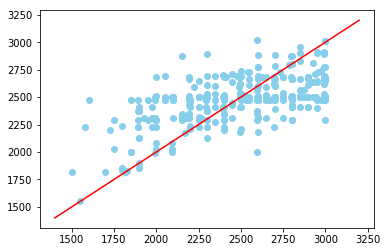

In [216]:
from matplotlib import pyplot as plt
#matplotlib inline
true_price=y['RentPrice'].values
pred_price=results.fittedvalues.values

x=np.linspace(1400,3200,100)
plt.figure()
plt.plot(x,x,'r-')
plt.scatter(true_price,pred_price,c='skyblue')
plt.show()

0.3304964172383217
0.29555112115089155


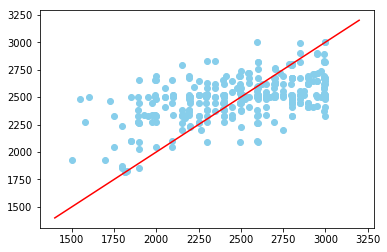

In [219]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

#增加多项式特征
def polynomial_model(degree=1):
    polynomial_features = PolynomialFeatures(degree=degree,
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    return pipeline

# 用1次特征最好
model = polynomial_model(degree=1)

single_data_=single_data.copy()
single_data_=pd.get_dummies(single_data_)

x_data=single_data_.iloc[:,1:]
y_data=single_data_.iloc[:,0]

x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,random_state=78)
model.fit(x_train,y_train)
print(model.score(x_train,y_train))
y_pred=model.predict(x_data)
print(model.score(x_data,y_data))

x=np.linspace(1400,3200,100)
plt.figure()
plt.plot(x,x,'r-')
plt.scatter(y_data,y_pred,c='skyblue')
plt.show()

效果都不是很好，因为数据量太小，特征太少。
